In [1]:
!git clone https://github.com/Omidzarexz/AnkleBiLSTMJointPrediction


Cloning into 'AnkleBiLSTMJointPrediction'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 206 (delta 45), reused 14 (delta 14), pack-reused 129 (from 1)
Receiving objects: 100% (206/206), 27.42 MiB | 15.44 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [18]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


# df_clean_train_12feature_cross_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_12feature_cross_subject.csv")
# df_clean_test_12feature_cross_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_12feature_cross_subject.csv")


# df_clean_train_16feature_cross_subject = pd.read_csv("/kaggle/working/AnkleBiLSTMJointPrediction/preprocessed_data/df_clean_train_16feature_cross_subject.csv")
# df_clean_test_16feature_cross_subject  = pd.read_csv("/kaggle/working/AnkleBiLSTMJointPrediction/preprocessed_data/df_clean_test_16feature_cross_subject.csv")


df_clean_train_16feature_within_subject = pd.read_csv("/kaggle/working/AnkleBiLSTMJointPrediction/preprocessed_data/df_clean_train_16feature_within_subject_txt25.csv")
df_clean_test_16feature_within_subject  = pd.read_csv("/kaggle/working/AnkleBiLSTMJointPrediction/preprocessed_data/df_clean_test_16feature_within_subject_txt25.csv")

df_clean_train = df_clean_train_16feature_within_subject
df_clean_test  = df_clean_test_16feature_within_subject

In [19]:
from scipy.signal import butter, filtfilt

def low_pass_butter(signal, cutoff=10, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)
feature_columns = [
    'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
    'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
    'MPU1_Roll','MPU1_Pitch',
    'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
    'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z',
    'MPU2_Roll','MPU2_Pitch'
]




df_filtered_trainig = pd.DataFrame()
df_filtered_test    = pd.DataFrame()
for col in feature_columns:
    df_filtered_trainig[col] = low_pass_butter( df_clean_train[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )
    df_filtered_test[col] = low_pass_butter( df_clean_test[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )







print("\ndf_filtered_trainig shape:",df_filtered_trainig.shape)
print("\ndf_filtered_test shape:",df_filtered_test.shape)



df_filtered_trainig shape: (16500, 16)

df_filtered_test shape: (992, 16)


In [20]:

from sklearn.preprocessing import  MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1, 1))
X_data_train = scaler.fit_transform(df_filtered_trainig[feature_columns].values)  # (T, 12)


y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_data_train = y_scaler.fit_transform(df_clean_train['angle'].values.reshape(-1, 1))





X_data_test = scaler.transform(df_filtered_test[feature_columns].values)

y_data_test = y_scaler.transform(df_clean_test["angle"].values.reshape(-1,1))


# تنظیمات پنجره
window_size = 200   #
horizon = 20        #
step_size = 20      #

# تابع پنجره‌بندی
def create_windows_with_labels(X, y, window_size, horizon, step_size):
    X_windows = []
    y_windows = []
    for i in range(0,  len(X) - window_size - horizon + 1, step_size):
        X_windows.append(X[i:i + window_size])
        y_windows.append(y[i + window_size : i + window_size + horizon])  # برچسب آخرین نمونه در پنجره
    return np.array(X_windows), np.array(y_windows)

# ایجاد پنجره‌ها
X_windows, y_windows = create_windows_with_labels(X_data_train, y_data_train,
                                                  window_size, horizon, step_size)
if horizon==1:
    y_windows = y_windows.reshape(-1,1)
else:
    y_windows = np.squeeze(y_windows, axis=2)





print(f"✅   (X_windows):(samples, time steps, features) → {X_windows.shape}")
print(f"✅  (y_windows): {y_windows.shape}")

step_size_for_test = 1
X_windows_test, y_windows_test = create_windows_with_labels(X_data_test, y_data_test,
                                                            window_size, horizon, step_size_for_test)

if horizon==1:
    y_windows_test = y_windows_test.reshape(-1,1)
else:
    y_windows_test = np.squeeze(y_windows_test, axis=2)

print(f"\n✅   (X_windows_test):(samples, time steps, features) → {X_windows_test.shape}")
print(f"✅  (y_windows_test): {y_windows_test.shape}")






✅   (X_windows):(samples, time steps, features) → (815, 200, 16)
✅  (y_windows): (815, 20)

✅   (X_windows_test):(samples, time steps, features) → (773, 200, 16)
✅  (y_windows_test): (773, 20)


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Bidirectional
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, GRU, Bidirectional, Dropout, ReLU, TimeDistributed, LayerNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2


LEARNING_RATE = 0.001
lambda_loss_amount = 0.0005


base_model  = load_model("/kaggle/input/20h-cross-subject/tensorflow2/default/1/best_lstm_model_reg.keras")





# Freeze early layers (optional)
for layer in base_model.layers[:4]:
    layer.trainable = False


x = base_model.layers[3].output  #
x = LayerNormalization(name='layer_norm_TL_1')(x)
x = Dropout(0.3, name='dropout_TL_1')(x)

x = Bidirectional(LSTM(32, return_sequences=True,
                           kernel_regularizer=l2(lambda_loss_amount)), name='bi_lstm_TL_1')(x)
x = LayerNormalization(name='layer_norm_TL_2')(x)
x = Dropout(0.3, name='dropout_TL_2')(x)

x = Bidirectional(LSTM(32, return_sequences=False,
                           kernel_regularizer=l2(lambda_loss_amount)), name='bi_lstm_TL_2')(x)
x = Dropout(0.3, name='dropout_TL_3')(x)

outputs = Dense(horizon, activation='linear', name='Dense_TL_1')(x)


transfer_model = models.Model(inputs=base_model.input, outputs=outputs)



# # Recompile
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                       loss='mae',
                       metrics=['mae'])

transfer_model.summary()
plot_model(transfer_model, show_shapes=True , dpi=45)


X_train, X_val, y_train, y_val = train_test_split( X_windows, y_windows, test_size=0.2,
                                                   shuffle=False, random_state=42)


callbacks = [
    ModelCheckpoint('best_lstm_model_reg.keras', save_best_only=True, monitor='val_loss',verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6,verbose=1)
]

history = transfer_model.fit(
    X_windows, y_windows,
    validation_data=(X_val, y_val),
    epochs=600,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 200, 128)       │         2,176 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 200, 256)       │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_norm_TL_1                 │ (None, 200, 256)       │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_TL_1 (Dropout)          │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_TL_1 (Bidirectional)    │ (None, 200, 64)        │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_norm_TL_2                 │ (None, 200, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_TL_2 (Dropout)          │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm_TL_2 (Bidirectional)    │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_TL_3 (Dropout)          │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_TL_1 (Dense)              │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,100 (1.40 MB)

 Trainable params: 100,756 (393.58 KB)

 Non-trainable params: 265,344 (1.01 MB)

Epoch 1/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7459 - mae: 0.4912
Epoch 1: val_loss improved from inf to 0.52898, saving model to best_lstm_model_reg.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 436ms/step - loss: 0.7416 - mae: 0.4871 - val_loss: 0.5290 - val_mae: 0.2843 - learning_rate: 0.0010
Epoch 2/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.5731 - mae: 0.3318
Epoch 2: val_loss improved from 0.52898 to 0.44005, saving model to best_lstm_model_reg.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5715 - mae: 0.3304 - val_loss: 0.4400 - val_mae: 0.2105 - learning_rate: 0.0010
Epoch 3/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.4903 - mae: 0.2644
Epoch 3: val_loss improved from 0.44005 to 0.37034, saving model to best_lstm_model_reg.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4891 - mae: 0.2634 - val_loss: 0.3703 - val_mae: 0.1566 - learning_rate: 0.0010
Epoch 4/600
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.4331 - mae: 0.2229
Epoch 

In [25]:
from tensorflow.keras.models import load_model
from sklearn.metrics import  mean_absolute_error

# model  = load_model("/kaggle/input/m/tensorflow2/default/1/best_lstm_model_reg.keras")
# پیش‌بینی روی داده تست-
y_pred_scaled = transfer_model.predict(X_windows_test)  # (N, 1)

# برگرداندن به مقیاس اصلی
y_pred_original = y_scaler.inverse_transform(y_pred_scaled)
y_true_original = y_scaler.inverse_transform(y_windows_test)




mae = mean_absolute_error(y_true_original, y_pred_original)
mae2 = mean_absolute_error(y_windows_test, y_pred_scaled)

print(f"Test MAE(scaled): {mae2:.3f}")
print(f"Test MAE(true value): {mae:.3f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step
Test MAE(scaled): 0.056
Test MAE(true value): 0.803


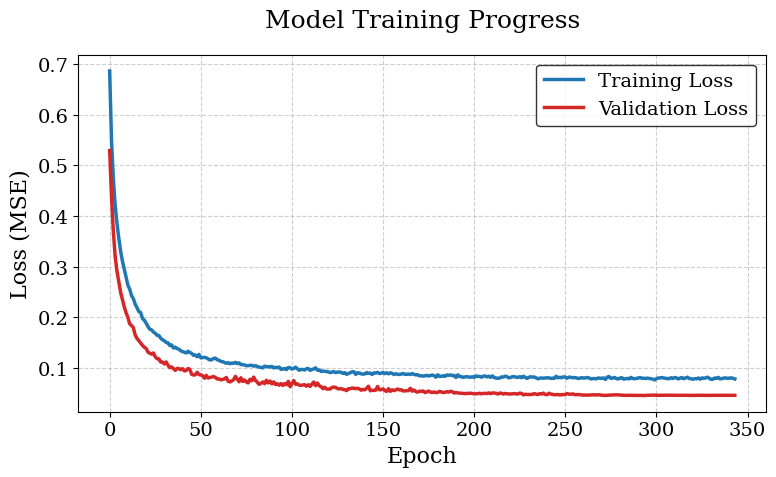

In [26]:
import matplotlib.pyplot as plt

# Set font sizes and styles for publication
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'serif',  # Optional: use serif font (common in papers)
    'figure.figsize': (8, 5)
})

# Plot training & validation loss
plt.plot(history.history["loss"], label="Training Loss", linewidth=2.5, color='tab:blue')
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2.5, color='tab:red')

# Add title and axis labels
plt.title("Model Training Progress", fontsize=18, pad=20)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

# Improve layout and add grid
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(frameon=True, loc='upper right', shadow=False, edgecolor='black')

# Use tight layout to prevent clipping
plt.tight_layout()

# Save high-resolution figure for your article
plt.savefig("training_validation_loss.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.savefig("training_validation_loss.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [27]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [9]:
y_true_original.shape

(16793, 100)

In [10]:
y_pred_original.shape

(16793, 100)

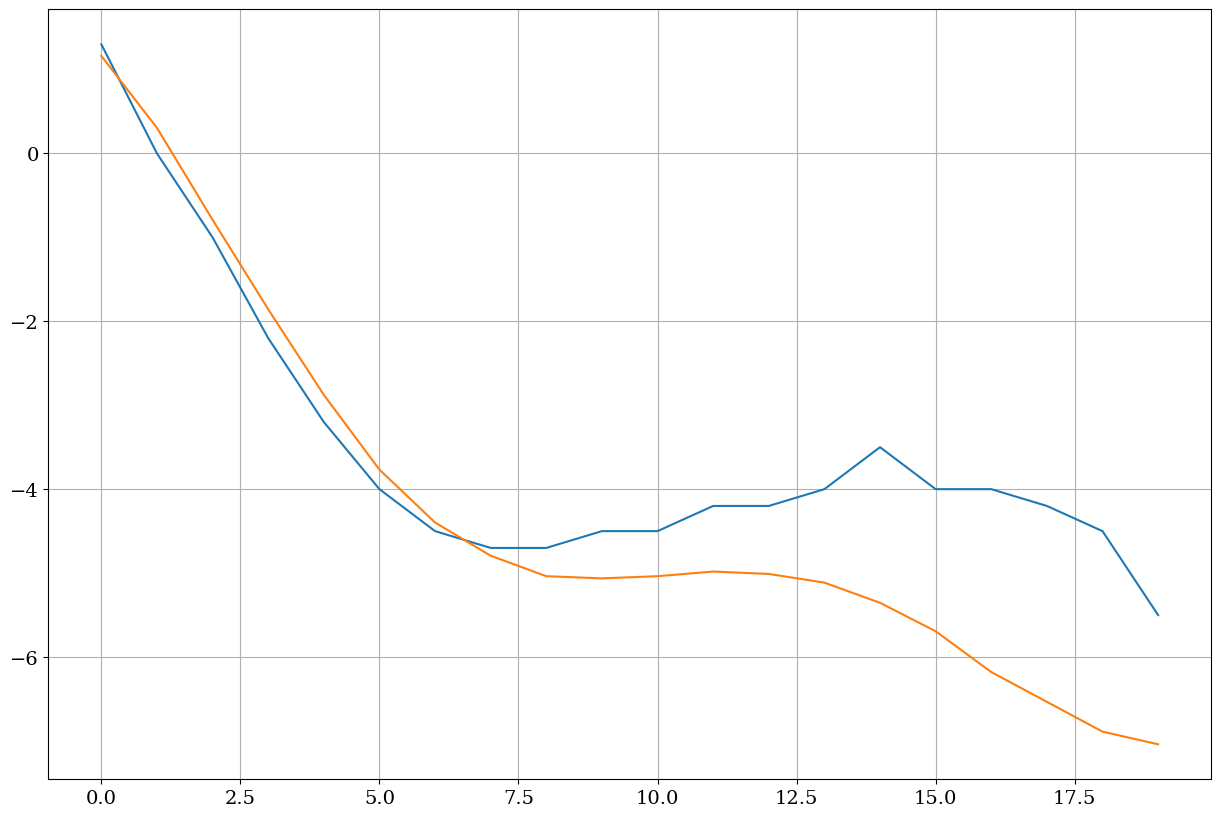

In [28]:


# time = np.arange(1, y_true_original.shape[0]+1) * 0.01
# time = time.reshape(-1, 1)

plt.figure(figsize=(15,10))
plt.plot(y_true_original[222,:])
plt.plot(y_pred_original[222,:])
plt.grid()

